In [1]:
from common.model.embedding.predefined.cbramod import CBraModFoundationEmbedder
from models.EEGAVI.base_EEGAVI.dataset import kd_train_dataset
from torch.utils.data import DataLoader
from models.EEGAVI.base_EEGAVI.EEGAVI import get_default_simple_EEGAVI

# model = WorkingEEGAVI(video_kd_size=100, audio_kd_size=100)
model = get_default_simple_EEGAVI()
ds = kd_train_dataset("../../../resources/AMIGOS/processed/spec.csv")
loader = DataLoader(ds, batch_size=2)

Some weights of VivitModel were not initialized from the model checkpoint at google/vivit-b-16x2-kinetics400 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/jacopo/PycharmProjects/progetto-tesi/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:174: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
x = next(iter(loader))
print(x[0]["EEGAVI"]["eeg"].shape)
x = x[0]["EEGAVI"]
x["kd"] = True

Opening raw data file ../../../resources/AMIGOS/processed/P01_31_raw.fif...
Isotrak not found
    Range : 0 ... 19885 =      0.000 ...   155.352 secs
Ready.


It is strongly recommended to pass the `sampling_rate` argument to `SeamlessM4TFeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.


Opening raw data file ../../../resources/AMIGOS/processed/P01_31_raw.fif...
Isotrak not found
    Range : 0 ... 19885 =      0.000 ...   155.352 secs
Ready.


It is strongly recommended to pass the `sampling_rate` argument to `SeamlessM4TFeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.


torch.Size([2, 14, 8, 200])


In [ ]:
res = model(x)

In [ ]:
res[0].shape

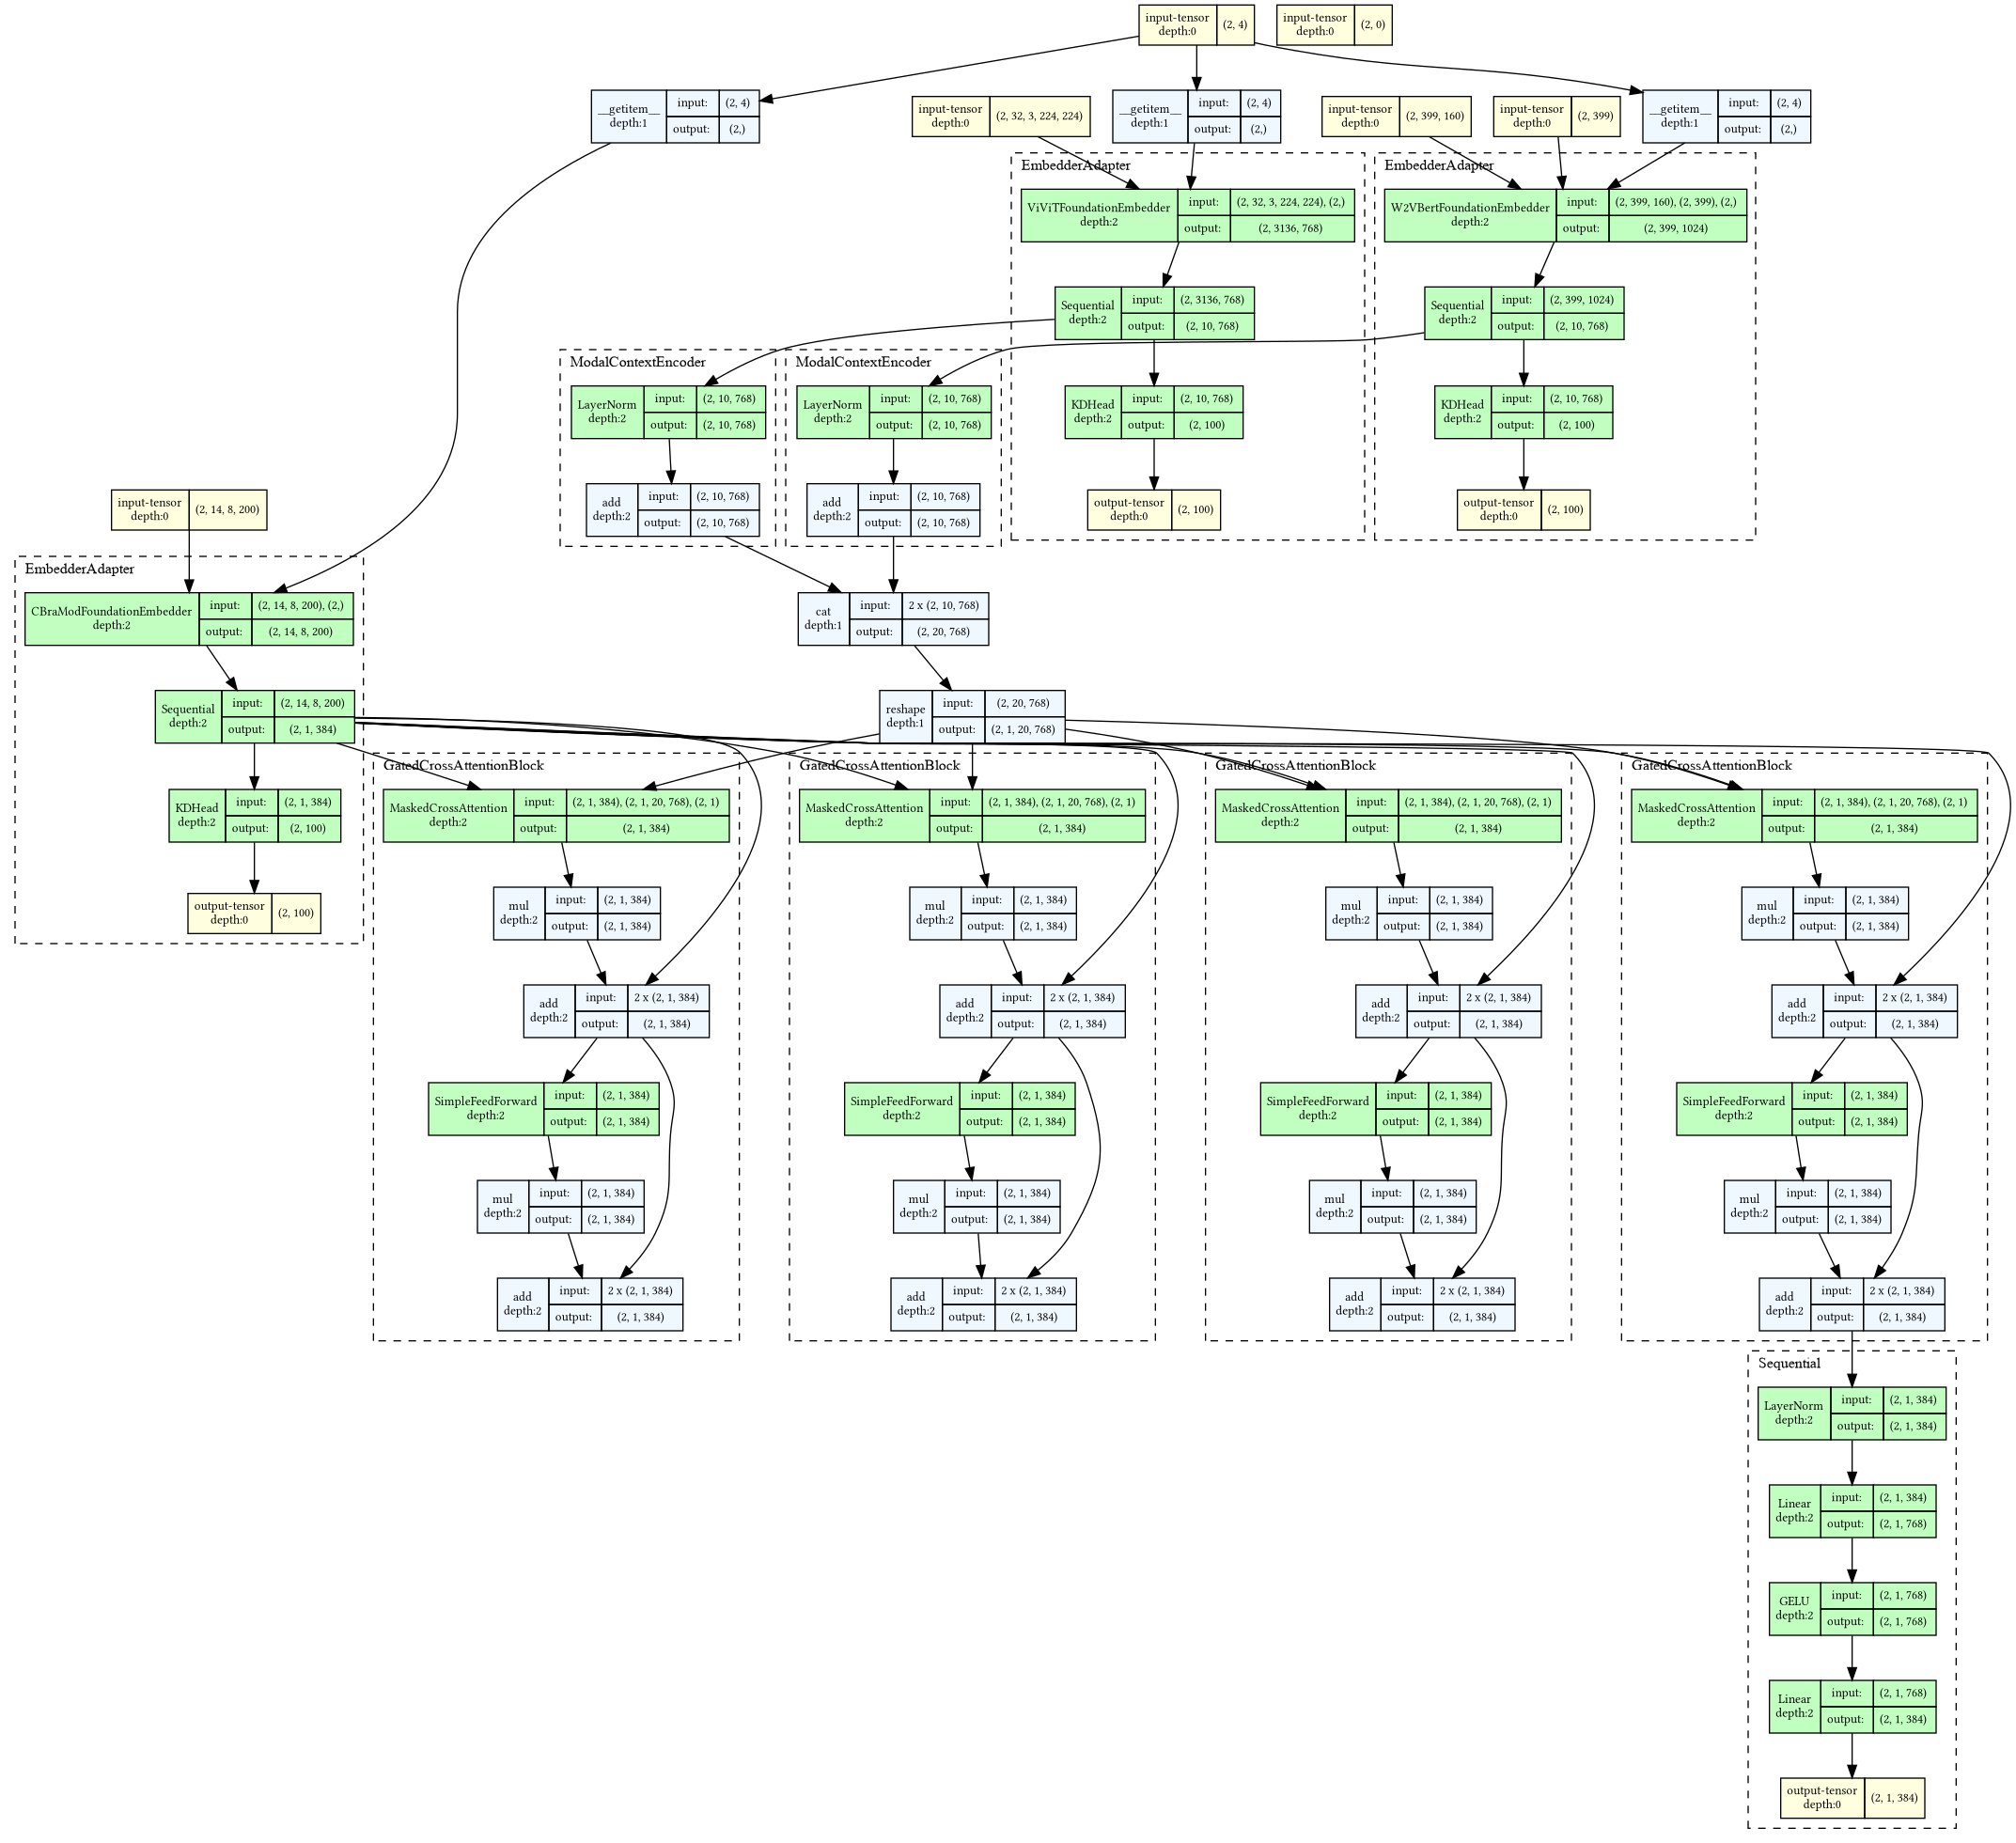

In [5]:
from torchview import draw_graph

import graphviz
graphviz.set_jupyter_format('png')

# Love this library !
model_graph = draw_graph(model, input_data={"x": x}, device='cpu', depth=2, expand_nested=True)
model_graph.visual_graph

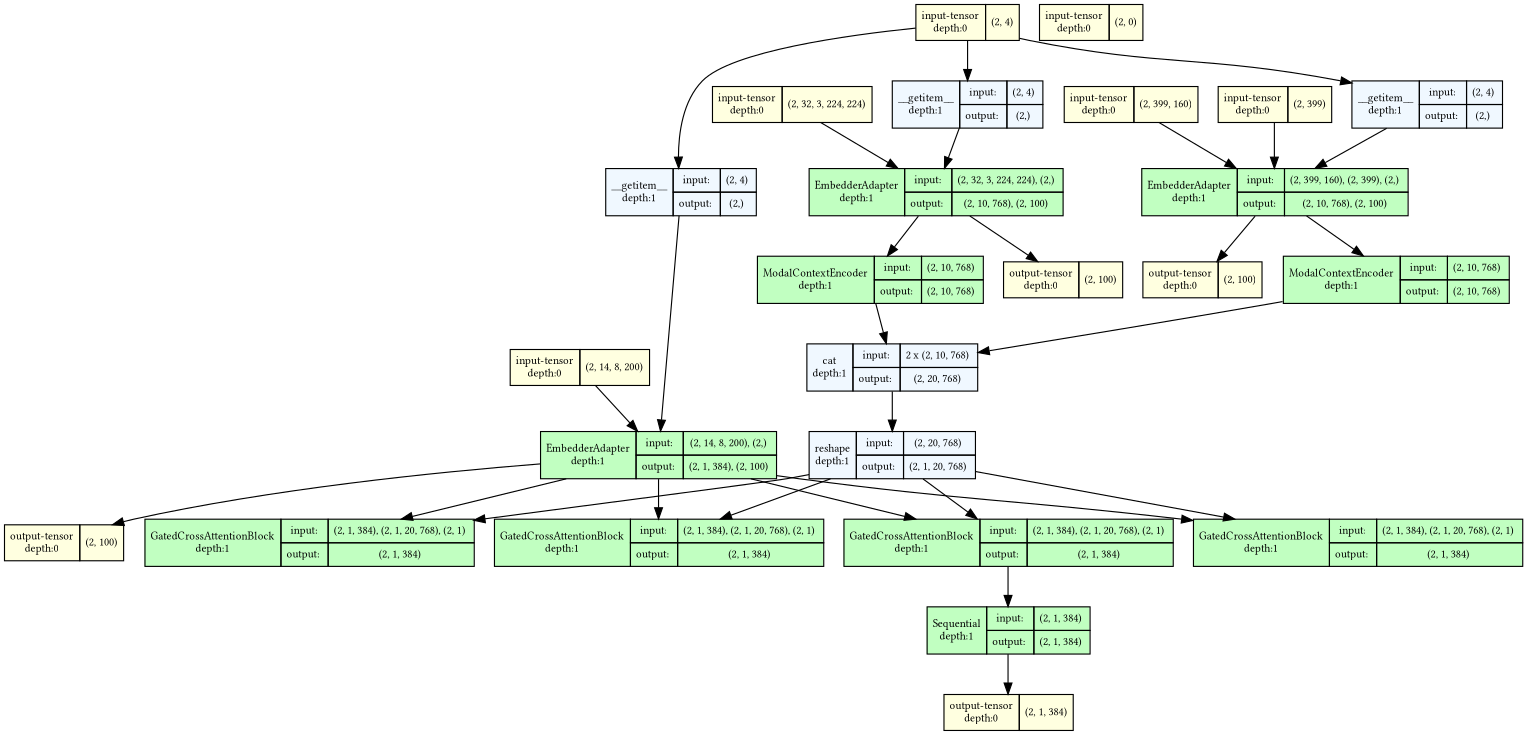

In [7]:
model_graph = draw_graph(model, input_data={"x": x}, device='cpu', depth=1, expand_nested=True)
model_graph.visual_graph

Given you still resample video/audio to **64 tokens each (D=768)** and plan to use **EEG as queries (Q)**, your choice—**gated cross-attention**—is spot on. You have genuine token sets on the KV side, so the LM/decoder (driven by EEG queries) can selectively ground into different audio/video regions. No need to switch paradigms.

Here’s how I’d set it up, plus a couple of tweaks that make it work reliably.

# Keep gated cross-attention (yes)

* You’ve got **M=64** tokens per modality → cross-attn has something to attend to. The gate is valuable to:

  1. stabilize early training (init near 0),
  2. let the model *decide* when EEG should trust A/V context,
  3. support future multi-media without refactors.

# How to fuse A+V with EEG (QKV design)

You have three good options; all keep the “gated-XAttn” flavor:

1. **Parallel, per-modality branches + residual add (recommended first)**

   * Compute two cross-attn branches in parallel:
     $Y_v = \text{XAttn}(Q_{eeg}, K_v, V_v)$, $Y_a = \text{XAttn}(Q_{eeg}, K_a, V_a)$
   * Gate each branch: $\hat Y_v = g_v \cdot P_v(Y_v)$, $\hat Y_a = g_a \cdot P_a(Y_a)$
   * Fuse by addition: $Q' = Q_{eeg} + \hat Y_v + \hat Y_a$
   * Use **separate K/V projections per modality** (don’t share) and tiny projection heads $P_v,P_a$ (Linear+Dropout).
   * Initialization: set $g_v=g_a\approx 0$ (e.g., logit init −3 to −5 or just a 0 param passed through tanh/sigmoid).

2. **Concat KV with modality tags (simple, cheaper)**

   * $K = [K_v; K_a]$, $V = [V_v; V_a]$; add a **modality embedding** to K and V.
   * Single gated branch: $Q' = Q_{eeg} + g \cdot P(\text{XAttn}(Q_{eeg}, K, V))$
   * Add a **length-balancing sampler** if one modality dominates token count.

3. **Competitive gating (mixture over modalities)**

   * Compute both branches, produce **softmax gates** from $Q_{eeg}$:
     $[w_v,w_a]=\text{softmax}(W\cdot \text{Pool}(Q_{eeg}))$
   * Fuse: $Q' = Q_{eeg} + w_v\hat Y_v + w_a\hat Y_a$
   * Helps when one modality is occasionally useless/noisy.

All three are fine; (1) is the most robust and easiest to ablate.

# Small but important details

* **Dim align:** Your video is already 768; audio is 1024→768 via ISAB/PMA projector. Keep **per-modality LayerNorm + Linear** into a **shared d\_model** (768).
* **Positional/temporal cues:** Even after resampling, inject **relative position encodings** per modality (RoPE or learned rel-bias). For videos, you can carry a **frame-index rel bias** into K/V; for audio, a **chunk index**. It helps EEG queries map to correct time neighborhoods.
* **Cross-modal time banding (optional):** If you can align EEG time indices to A/V indices, add a **banded attention mask** that softly favors nearby K/V timesteps (e.g., bias matrix with −∞ outside a ±Δ window).
* **Depth placement:** Interleave blocks:
  `[SelfAttn(EEG) → GatedXAttn(A) → GatedXAttn(V) → MLP] × N`
  or use the concat-KV variant once per block to save compute.
* **Gates:** Scalar per branch is usually enough. If unstable, switch to **vector gates** (per-channel) with LN on branch outputs.
* **Token budget:** 64v + 64a = 128 KV tokens. If EEG query length is large, consider **KV downsample** to 32 each without big quality loss. Keep head dim modest (e.g., 8 heads × 96 = 768).

# A clean “braided” block (PyTorch-ish, concise)

```python
class GatedXAttnBranch(nn.Module):
    def __init__(self, d_model, n_heads, pdrop=0.0, gate_init=0.0):
        super().__init__()
        self.attn = nn.MultiheadAttention(d_model, n_heads, dropout=pdrop, batch_first=True)
        self.proj = nn.Sequential(nn.Linear(d_model, d_model), nn.Dropout(pdrop))
        self.ln_kv = nn.LayerNorm(d_model)
        self.gate = nn.Parameter(torch.tensor(gate_init))  # use tanh/sigmoid on forward

    def forward(self, q, kv, attn_mask=None, key_padding_mask=None):
        kv = self.ln_kv(kv)
        y, _ = self.attn(q, kv, kv, attn_mask=attn_mask, key_padding_mask=key_padding_mask)
        y = self.proj(y)
        g = torch.tanh(self.gate)  # scalar gate
        return g * y

class EEGAVBlock(nn.Module):
    def __init__(self, d_model=768, n_heads=8, pdrop=0.1):
        super().__init__()
        self.ln_q = nn.LayerNorm(d_model)
        self.av_branch_v = GatedXAttnBranch(d_model, n_heads, pdrop, gate_init=0.0)
        self.av_branch_a = GatedXAttnBranch(d_model, n_heads, pdrop, gate_init=0.0)
        self.mlp = nn.Sequential(nn.LayerNorm(d_model), nn.Linear(d_model, 4*d_model),
                                 nn.GELU(), nn.Dropout(pdrop), nn.Linear(4*d_model, d_model))
    def forward(self, q_eeg, kv_v, kv_a, masks=None):
        x = self.ln_q(q_eeg)
        yv = self.av_branch_v(x, kv_v, attn_mask=masks.get('v_attn') if masks else None)
        ya = self.av_branch_a(x, kv_a, attn_mask=masks.get('a_attn') if masks else None)
        q = q_eeg + yv + ya
        q = q + self.mlp(q)
        return q
```

# When would I *not* use gated X-Attn here?

* If you later **collapse A/V to one pooled vector** each—then switch to **Conditional LayerNorm / FiLM** or **prefix tokens**. But as long as you keep **64 tokens**, gated cross-attn is the right hammer.

# Quick ablation plan (cheap + decisive)

1. **Concat-KV vs parallel branches:** measure validation loss and alignment metrics; parallel almost always wins in noisy-modality settings.
2. **Gates on/off:** init gates to 0 vs fixed 1. Gated usually trains smoother and avoids over-conditioning.
3. **Token counts:** 64→32 per modality; check that accuracy/CE barely moves while latency drops.
4. **Band mask:** no band vs ±4/±8 time windows; expect better temporal grounding.

# Reminder

Since we moved firmly to **EEG-as-Q, A/V-as-KV with per-modality gates**, we should **update the architecture plot (image.png)** to reflect:

* per-modality resampler to 64 tokens,
* two gated cross-attn branches into the EEG stream,
* optional concat-KV path as a variant.

If you want, I can draft the exact node/edge layout text so you can regenerate the figure you keep in `Pasted image.png`.


This is a great question about how to best leverage rich human annotations. Given that you're building a foundation model, I'd recommend **using these annotations as additional modalities** rather than just supervised targets, for several compelling reasons:

**Why treat annotations as modalities:**

**Richer representation learning**: Valence/arousal/dominance and emotion labels contain structured information about human subjective experience that can help your model learn more nuanced multimodal representations. This is especially valuable for EEG data, where the subjective experience is often what you're trying to decode.

**Foundation model flexibility**: As a foundation model, you want representations that can generalize to many downstream tasks. Encoding these annotations as modalities makes them available for various use cases - some might need arousal prediction, others emotion classification, others might benefit from valence-aware representations.

**Cross-modal learning**: The model can learn relationships between EEG patterns, video content, and subjective ratings. This could help it understand, for example, how certain EEG signatures relate to high arousal states or specific emotions.

**Practical implementation approaches:**

1. **Embed the annotations**: Create simple embedders for the numerical ratings (valence/arousal/dominance/familiarity/liking) and categorical emotions
2. **Multi-task learning**: Include reconstruction/prediction losses for these modalities alongside your main objectives
3. **Masking strategy**: During training, randomly mask some annotation modalities so the model learns to infer missing subjective states

**Hybrid approach**: You could do both - use them as modalities for representation learning AND as supervised targets for some training objectives. This gives you the benefits of both approaches.

This seems particularly powerful for EEG foundation models since subjective experience is often the ground truth you're ultimately trying to understand from neural signals.

Your friend is **partly right**, but the key question is: *do you have those annotations at inference time?*

Let’s break it down:

---

### 1. If ratings **are not available at inference** (most foundation-model scenarios)

* Treating them as a full **input modality** is risky → it creates **data leakage**: the model learns to depend on signals it won’t see later.
* In this case, the safer approach is:

  * Use them as **supervision** (multi-task targets).
  * Use them as **privileged info** (teacher–student KD).
  * Optionally allow them as an **auxiliary branch** with **modality dropout**, so the model learns to work **with or without** them.

✅ This keeps the foundation model usable for downstream tasks where ratings aren’t present.

---

### 2. If ratings **could be available at inference** (e.g., interactive personalization)

* Then yes, you *can* treat them as an **additional modality**.

  * Encode ratings with a small MLP.
  * Fuse them with EEG embeddings (e.g., gated fusion).
  * Train with **modality dropout**, so the model doesn’t collapse if they’re missing.

✅ This makes sense if your deployment setting sometimes collects quick valence/arousal sliders or self-reports.

---

### 3. Foundation model philosophy

* A **foundation model** is meant to be widely usable across settings.
* That means you should **not assume rare modalities at inference**.
* Instead, ratings are best used to **shape the representation during training**—through **supervision, KD, contrastive alignment**—but not as a dependency at runtime.

---

🔑 **So, your friend is right only if you know ratings will be present at inference.**
For a general-purpose foundation EEG model, it’s safer to keep them as **training signals** rather than a core modality.

---

Do you want me to sketch an updated **architecture diagram** that shows the difference between:

1. “ratings as a modality” path (your friend’s suggestion)
2. “ratings as supervision + KD” path (my suggestion)?


Your friend makes an excellent point that I should have emphasized more strongly. They're absolutely right about the **inference availability problem** - this is a critical consideration for foundation models.

**The core issue**: If your foundation model learns to rely on subjective ratings as input modalities, it becomes less useful for real-world applications where you typically only have EEG/video/audio but no human annotations.

**Your friend's suggestions are much more practical:**

**Multi-task supervision**: Use ratings as additional loss targets alongside your main objectives. The model learns to predict these from EEG+video+audio, making it better at understanding subjective states without requiring them as input.

**Privileged information in KD**: During knowledge distillation, let the teacher model see the annotations but train the student to match the teacher's representations using only EEG+video+audio. This transfers the knowledge without creating dependency.

**Auxiliary branch with modality dropout**: This is particularly clever - train with annotations sometimes present, sometimes absent. The model learns robust representations that can leverage annotations when available but don't break without them.

**Why this matters for your EEG foundation model:**
- Real-world EEG applications rarely have concurrent subjective ratings
- You want the model to be deployable in clinical, BCI, or research settings where only physiological + stimulus data exists
- The annotations help training but shouldn't become a crutch

Your friend's approach gives you the representational benefits of the rich annotation data while maintaining the practical utility of your foundation model. This is definitely the better strategy for real-world deployment.Here’s a concise table of the **best options** for handling your ratings (valence, arousal, dominance, liking, familiarity, emotions) in the context of building a **foundation EEG model**:

| **Option**                                 | **How to use ratings**                                                                                                                           | **When it makes sense**                                                                     | **Pros**                                                                     | **Cons / Risks**                                                |
| ------------------------------------------ | ------------------------------------------------------------------------------------------------------------------------------------------------ | ------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------- | --------------------------------------------------------------- |
| **Supervision (multi-task)**               | Predict V/A/D (ordinal), emotions (multi-label), liking/familiarity (regression). Heads dropped at inference.                                    | Always (default)                                                                            | Shapes representations with affective info; simple to add.                   | No direct teacher guidance; only works via ground-truth labels. |
| **Privileged Info (Teacher–Student / KD)** | Teacher sees EEG+ratings, student only EEG. Distill logits/embeddings.                                                                           | Always, if ratings exist in training data                                                   | Injects human affect structure; student usable without ratings.              | More complex training; need distillation tuning.                |
| **Optional Input Modality**                | Encode ratings as a sidecar MLP, fuse with EEG (e.g. gated). Use modality dropout.                                                               | If ratings may sometimes be available at inference (e.g. interactive apps, personalization) | Can boost performance when ratings are present; robust fallback when absent. | Extra parameters; risk of over-reliance if dropout not used.    |
| **Pretraining Signals (ratings-free)**     | Self-supervised EEG (masked TS, temporal order), contrastive EEG↔stimulus. Ratings only used indirectly (e.g. pairwise valence/arousal ranking). | Foundation pretraining stage                                                                | Keeps backbone general; ratings guide structure without being inputs.        | Ratings not directly predicted; weaker supervision signal.      |

---

✅ **Recommended mix for a foundation model:**

1. **Always**: Supervision (multi-task heads).
2. **Additionally**: Teacher–student KD to distill richer structure.
3. **Optionally**: Sidecar modality (with dropout) if ratings might be available at inference.
4. **Base pretraining**: Keep EEG backbone ratings-free.

---

Would you like me to **update the architecture diagram** so it clearly shows these three branches (supervision, KD, optional modality)? That way the design is visually consistent with your `Pasted image.png`.


That’s a really good catch 👍

Yes — if your **sidecar branch directly takes the *ground-truth ratings*** (valence/arousal/dominance, emotions, liking, familiarity) as **inputs** during training **and you don’t have them at inference**, then it *is* a form of **label leakage**. The model would be “cheating,” since it sees the answers while learning.

---

### How to avoid leakage

* **Don’t feed ground-truth ratings as features unless you also expect them at inference.**
* Instead, if you want a “ratings sidecar” branch, use:

  * **Predicted ratings** from another model (e.g. a lightweight estimator trained separately on stimuli or early EEG features).
  * **Noisy / partial user inputs** at inference (e.g. quick sliders, few ratings for personalization).
  * **Auxiliary embeddings** derived from clustering ratings across the dataset, so you’re not feeding the raw labels.

---

### Correct framing

* **Training-only → supervision / KD**: Ratings are used to shape representation (safe).
* **Inference-time optional modality** → only valid if you **really will have some rating inputs** at test time (e.g. user self-reports).

---

🔑 So the sidecar isn’t inherently bad — it’s only “leakage” if you train with labels as inputs and then don’t have them at inference. If you want a truly general **foundation EEG model**, keep the ratings in the **supervision / KD role**. Only add them as an **input modality** if your application setting makes them *available at runtime*.

---

Do you want me to propose a clean **two-mode architecture** (one with ratings-as-supervision-only, one with ratings-as-input when available) so you can keep both options without leakage?


BUT if someone wants to fintune the model they don't need the vda data right? It is already gated!

Correct 👍

If you design the **ratings sidecar** with a **gate (modality dropout / fusion switch)**, then during **finetuning**:

* A user who **has V/A/D ratings** (or some proxy, like sliders or predicted ratings) can plug them into the sidecar.
* A user who **does not have V/A/D ratings** can **ignore the branch** — the EEG backbone and heads are already trained to work *without* it, because you forced that behavior during pretraining with dropout.

So:

* **Fine-tuning without V/A/D data → totally valid.** The model falls back to the EEG-only pathway.
* **Fine-tuning with V/A/D data → possible boost.** The gate lets you fuse them, but they’re not required.

This is exactly the reason for the gating trick: it future-proofs the model so that the **foundation checkpoint** can be finetuned **with or without** ratings.

👉 In practice, during finetuning, you’d just set the `has_sidecar=False` flag (or drop the input) and the architecture continues to function.

Do you want me to annotate your **architecture diagram** so it explicitly shows that the sidecar is *optional at pretraining and optional at finetuning*?
